In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class PLSI:
    def __init__(self, n_topics, max_iter=100, tol=1e-4, random_state=None):
        self.n_topics = n_topics
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X):
        """
        X: document-word matrix (docs x words)
        """
        np.random.seed(self.random_state)
        n_docs, n_words = X.shape

        # Initialize parameters
        self.P_w_z = np.random.rand(self.n_topics, n_words)
        self.P_w_z /= self.P_w_z.sum(axis=1, keepdims=True)

        self.P_z_d = np.random.rand(n_docs, self.n_topics)
        self.P_z_d /= self.P_z_d.sum(axis=1, keepdims=True)

        prev_likelihood = -np.inf
        self.likelihoods = []

        for iteration in range(self.max_iter):
            # E-step: Compute P(z|d,w)
            P_z_dw = np.zeros((n_docs, n_words, self.n_topics))
            for z in range(self.n_topics):
                P_z_dw[:, :, z] = self.P_z_d[:, [z]] * self.P_w_z[[z], :]

            P_z_dw /= P_z_dw.sum(axis=2, keepdims=True) + 1e-12

            # M-step
            # Update P(w|z)
            for z in range(self.n_topics):
                numerator = (X * P_z_dw[:, :, z]).sum(axis=0)
                self.P_w_z[z, :] = numerator / (numerator.sum() + 1e-12)

            # Update P(z|d)
            for d in range(n_docs):
                numerator = (X[d, :, None] * P_z_dw[d, :, :]).sum(axis=0)
                self.P_z_d[d, :] = numerator / (numerator.sum() + 1e-12)

            # Compute log-likelihood
            Pw_d = np.zeros((n_docs, n_words))
            for z in range(self.n_topics):
                Pw_d += self.P_z_d[:, [z]] * self.P_w_z[[z], :]

            likelihood = np.sum(X * np.log(Pw_d + 1e-12))
            self.likelihoods.append(likelihood)

            if np.abs(likelihood - prev_likelihood) < self.tol:
                print(f"✅ Converged at iteration {iteration}")
                break

            prev_likelihood = likelihood

            if iteration % 5 == 0 or iteration == self.max_iter - 1:
                print(f"Iteration {iteration}, log-likelihood: {likelihood:.4f}")

        print("Training complete.")
        return self


    def plot_likelihood(self):
        """Plot log-likelihood over iterations"""
        plt.figure(figsize=(6, 4))
        plt.plot(self.likelihoods, marker='o')
        plt.title("Log-Likelihood vs Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Log-Likelihood")
        plt.grid(True)
        plt.show()

    def plot_doc_topics(self):
        """Visualize P(z|d) as bar chart"""
        plt.figure(figsize=(8, 5))
        for d in range(self.P_z_d.shape[0]):
            plt.bar(np.arange(self.n_topics) + d*(self.n_topics + 0.5),
                    self.P_z_d[d], label=f'Doc {d+1}')
        plt.title("Topic Distribution per Document")
        plt.xlabel("Topic index (offset per doc)")
        plt.ylabel("P(z|d)")
        plt.legend()
        plt.show()

    def plot_word_topics(self, vocab=None):
        """Visualize top words in each topic as heatmap"""
        plt.figure(figsize=(10, 6))
        plt.imshow(self.P_w_z, aspect='auto', cmap='viridis')
        plt.colorbar(label='P(w|z)')
        plt.title("Word Distribution per Topic")
        plt.xlabel("Words" if vocab is None else "Vocabulary")
        plt.ylabel("Topics")
        if vocab is not None:
            plt.xticks(np.arange(len(vocab)), vocab, rotation=90)
        plt.tight_layout()
        plt.show()

    def topic_words(self, n_top_words=10, vocab=None):
        for i in range(self.n_topics):
            top_idx = np.argsort(self.P_w_z[i, :])[::-1][:n_top_words]
            words = [vocab[j] if vocab is not None else str(j) for j in top_idx]
            print(f"Topic {i+1}: {' '.join(words)}")


Iteration 0, log-likelihood: -302.7898
Iteration 5, log-likelihood: -264.3450
✅ Converged at iteration 9
Training complete.

Top words per topic:
Topic 1: bananas fresh mango sweet served restaurant salad breakfast
Topic 2: work trucks transportation trains train traffic today taking


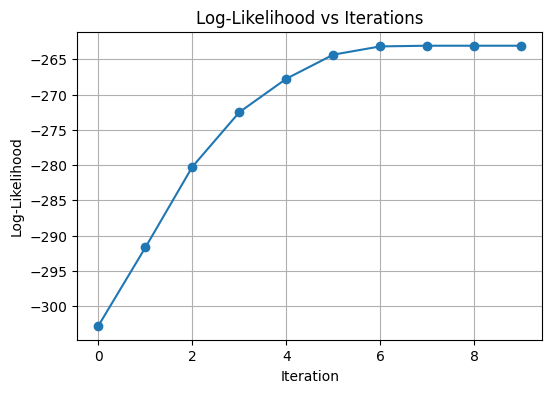

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

docs = [
    "I bought fresh apples, bananas, and oranges from the farmer's market this morning.",
    "The mango smoothie I had for breakfast was rich and refreshing.",
    "Trains and buses are the most common forms of public transportation in big cities.",
    "I prefer driving my car to work instead of taking the crowded metro every day.",
    "My friend brought a basket of ripe mangoes and juicy pineapples for the picnic.",
    "The traffic was heavy today because several trucks were blocking the main road.",
    "After gym, I love having a bowl of fruit salad with apple, orange, and papaya.",
    "Electric cars are becoming more popular as fuel prices continue to rise.",
    "We missed the train and had to take a bus to reach our destination.",
    "The restaurant served a dessert made of fresh bananas and sweet mango sauce."
]
# ===============================================


# Create document-word matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(docs).toarray()
vocab = vectorizer.get_feature_names_out()

# Train pLSI
plsi = PLSI(n_topics=2, max_iter=100, random_state=42)
plsi.fit(X)

# Show results
print("\nTop words per topic:")
plsi.topic_words(n_top_words=8, vocab=vocab)


# Plots
plsi.plot_likelihood()


